# Practica 3 COMPARACIÓN CPU VS GPU

### JORDI BLASCO LOZANO
### computacion de alto rendimiento

## Introducción 
En esta práctica, hemos explorado y comparado el rendimiento de una CPU y una GPU en la tarea de reconocimiento de imágenes utilizando un modelo de aprendizaje profundo preentrenado, ResNet18. El objetivo principal ha sido entender cómo la elección del hardware puede afectar significativamente el tiempo de procesamiento y cómo este conocimiento puede ser aplicado en proyectos reales.

## Objetivos de la Práctica

- Comparar los tiempos de ejecución en CPU y GPU para la tarea de procesamiento de imágenes.
- Reflexionar sobre cómo esta diferencia de rendimiento puede influir en aplicaciones del mundo real, como el reconocimiento facial.


## Pasos Realizados

### 1. Preparación del Entorno
- Instalacion e importacion de las bibliotecas necesarias
- Configuracion del debugger para que se puedan imprimir al nivel de log que se quiera (INFO, DEBUGG)

In [169]:
import torch
import time
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
import sys
import os
import logging
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

In [182]:
# nivel de log
DEBUG = True
INFO = True

log_level = logging.DEBUG if DEBUG else logging.INFO
logger = logging.getLogger()
logger.setLevel(log_level)

if not DEBUG:
    warnings.simplefilter("ignore", UserWarning)

if logger.hasHandlers():
    logger.handlers.clear()
handler = logging.StreamHandler()
handler.setLevel(log_level)
asctime_format = '%Y-%m-%d %H:%M:%S'
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt=asctime_format)
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.debug("Modo DEBUG activado")
logger.info("Modo INFO activado")

2025-02-11 18:16:12 - DEBUG - Modo DEBUG activado
2025-02-11 18:16:12 - INFO - Modo INFO activado


### 2. Carga de Bibliotecas y Modelo
- Comprobacion de si tenemos una gpu con cuda en el sistema
- Carga del modelo preentrenado ResNet18 y configuración en modo evaluación.
- Carga de imágenes de prueba.
- Aplicación de transformaciones a las imágenes para ajustarlas al tamaño requerido por el modelo.
- Medición del tiempo de procesamiento en CPU.
- Medición del tiempo de procesamiento en GPU (si está disponible).
- Registro de los tiempos de ejecución para diferentes tamaños de imágenes en una string en formato markdonw.


In [183]:
class PracticaCPUvsGPU:
    def __init__(self):
        """
        Inicializa la práctica.
        """
        


        logging.debug("GPU disponible (inicial): %s", torch.cuda.is_available())
        logging.debug("Número de GPUs (inicial): %s", torch.cuda.device_count())
    
        # Definir las resoluciones a comparar
        self.resoluciones = [(224, 224), (512, 512), (1024, 1024), (2048, 2048), (4096, 4096)]
        
        # Cargar el modelo ResNet18 para CPU y establecerlo en modo evaluación

        self.model_cpu = models.resnet18(pretrained=True)
        self.model_cpu.eval()
        
        # Verificar GPU y cargar modelo en GPU si aparece disponible
        self.gpu_disponible = torch.cuda.is_available()
        if self.gpu_disponible:
            self.model_gpu = models.resnet18(pretrained=True).to('cuda')
            self.model_gpu.eval()
        else:
            self.model_gpu = None
        
        # Directorio donde se encuentran las imágenes
        self.imagenes_dir = "Fotos ejemplo"
        # Lista de rutas de imagen (Foto facial 1.jpg a Foto facial 5.jpg)
        self.image_paths = [os.path.join(self.imagenes_dir, f"Foto facial {i}.jpg") for i in range(1, 6)]
    
    def run_measurements(self):
        """
        Recorre las imágenes y mide los tiempos de ejecución sobre CPU y GPU (si está disponible),
        registrando los resultados mediante logging.
        """
        for path in self.image_paths:
            try:
                image = Image.open(path)
            except Exception as e:
                logging.error("Error al abrir la imagen %s: %s", path, e)
                continue

            for res in self.resoluciones:
                # Definir la transformación para la resolución actual
                transform_res = transforms.Compose([
                    transforms.Resize(res),
                    transforms.ToTensor()
                ])
    
                # Convertir la imagen a tensor y añadir dimensión batch
                input_tensor = transform_res(image).unsqueeze(0)
    
                # Medición en CPU 
                start_cpu = time.time()
                with torch.no_grad():
                    _ = self.model_cpu(input_tensor)
                tiempo_cpu = time.time() - start_cpu
    
                resultado = f"Imagen: {path} | Tamaño: {res[0]}x{res[1]} | Tiempo en CPU: {tiempo_cpu:.4f} segundos"
    
                # Medición en GPU si está disponible
                if self.gpu_disponible:
                    input_tensor_gpu = input_tensor.to('cuda')
                    start_gpu = time.time()
                    with torch.no_grad():
                        _ = self.model_gpu(input_tensor_gpu)
                    torch.cuda.synchronize()  # Asegurarse de que la GPU finalice la operación
                    tiempo_gpu = time.time() - start_gpu
                    resultado += f" | Tiempo en GPU: {tiempo_gpu:.4f} segundos"
                else:
                    resultado += " | GPU no disponible."
    
                logging.info(resultado)
    
    def generar_tabla_markdown(self) -> str:
        """
        Genera una tabla en formato Markdown con los tiempos de ejecución en CPU y GPU.
        
        Returns:
            Una cadena con la tabla Markdown.
        """
        table_lines = []
        # Cabecera de la tabla Markdown
        table_lines.append("| Imagen | Tamaño | Tiempo CPU (s) | Tiempo GPU (s) |")
        table_lines.append("|--------|--------|----------------|----------------|")
    
        for path in self.image_paths:
            try:
                image = Image.open(path)
            except Exception as e:
                table_lines.append(f"| {path} | Error al abrir imagen: {e} | - | - |")
                continue
    
            for res in self.resoluciones:
                transform_res = transforms.Compose([
                    transforms.Resize(res),
                    transforms.ToTensor()
                ])
                input_tensor = transform_res(image).unsqueeze(0)
                start_cpu = time.time()
                with torch.no_grad():
                    _ = self.model_cpu(input_tensor)
                tiempo_cpu = time.time() - start_cpu
    
                if self.gpu_disponible:
                    input_tensor_gpu = input_tensor.to('cuda')
                    start_gpu = time.time()
                    with torch.no_grad():
                        _ = self.model_gpu(input_tensor_gpu)
                    torch.cuda.synchronize()
                    tiempo_gpu = time.time() - start_gpu
                    tiempo_gpu_str = f"{tiempo_gpu:.4f}"
                else:
                    tiempo_gpu_str = "N/A"
    
                table_lines.append(f"| {os.path.basename(path)} | {res[0]}x{res[1]} | {tiempo_cpu:.4f} | {tiempo_gpu_str} |")
    
        return "\n".join(table_lines)

    def run_all(self):
        """
        Ejecuta el análisis (mediciones) y genera la tabla Markdown.
        """
        self.run_measurements()
        md_table = self.generar_tabla_markdown()
        
        return md_table
    


### 3 Ejecucion del modelo
- Carga de la clase en una variable
- Ejecucion del programa y guardado de la tabla de markdonw en una variable


In [189]:
practica = PracticaCPUvsGPU()
tabla = practica.run_all()

logging.debug("Tabla Markdown generada:\n%s", tabla)

2025-02-11 18:24:40 - DEBUG - GPU disponible (inicial): False
2025-02-11 18:24:40 - DEBUG - Número de GPUs (inicial): 0
2025-02-11 18:24:40 - INFO - Imagen: Fotos ejemplo/Foto facial 1.jpg | Tamaño: 224x224 | Tiempo en CPU: 0.0455 segundos | GPU no disponible.
2025-02-11 18:24:40 - INFO - Imagen: Fotos ejemplo/Foto facial 1.jpg | Tamaño: 512x512 | Tiempo en CPU: 0.1460 segundos | GPU no disponible.
2025-02-11 18:24:41 - INFO - Imagen: Fotos ejemplo/Foto facial 1.jpg | Tamaño: 1024x1024 | Tiempo en CPU: 0.6473 segundos | GPU no disponible.
2025-02-11 18:24:43 - INFO - Imagen: Fotos ejemplo/Foto facial 1.jpg | Tamaño: 2048x2048 | Tiempo en CPU: 2.2095 segundos | GPU no disponible.
2025-02-11 18:24:52 - INFO - Imagen: Fotos ejemplo/Foto facial 1.jpg | Tamaño: 4096x4096 | Tiempo en CPU: 8.3688 segundos | GPU no disponible.
2025-02-11 18:24:52 - INFO - Imagen: Fotos ejemplo/Foto facial 2.jpg | Tamaño: 224x224 | Tiempo en CPU: 0.0643 segundos | GPU no disponible.
2025-02-11 18:24:52 - INFO -

| Imagen | Tamaño | Tiempo CPU (s) | Tiempo GPU (s) |
|--------|--------|----------------|----------------|
| Foto facial 1.jpg | 224x224 | 0.0150 | 0.0030 |
| Foto facial 1.jpg | 512x512 | 0.0540 | 0.0030 |
| Foto facial 1.jpg | 1024x1024 | 0.2046 | 0.0090 |
| Foto facial 2.jpg | 224x224 | 0.0150 | 0.0030 |
| Foto facial 2.jpg | 512x512 | 0.0530 | 0.0040 |
| Foto facial 2.jpg | 1024x1024 | 0.2180 | 0.0090 |
| Foto facial 3.jpg | 224x224 | 0.0160 | 0.0030 |
| Foto facial 3.jpg | 512x512 | 0.0540 | 0.0030 |
| Foto facial 3.jpg | 1024x1024 | 0.2180 | 0.0100 |
| Foto facial 4.jpg | 224x224 | 0.0160 | 0.0040 |
| Foto facial 4.jpg | 512x512 | 0.0540 | 0.0030 |
| Foto facial 4.jpg | 1024x1024 | 0.2208 | 0.0110 |
| Foto facial 5.jpg | 224x224 | 0.0160 | 0.0030 |
| Foto facial 5.jpg | 512x512 | 0.0550 | 0.0040 |
| Foto facial 5.jpg | 1024x1024 | 0.2240 | 0.0090 |

###  4 Uso de un pandas dataset y luego calcular las medias de cada tamaño de imagen para la CPU y GPU

- Leemos linea por linea la string markdown
- Creamos un dataset para incluir los datos
- Aplicamos una mascara por si no hay GPU en nuestra maquina y en lugar de poner N/A lo sustituimos por un np.nan
- Calculamos las medias y nos las guardamos en orden de menor tamaño de imagen a mayor sacando el entero de la string y creando una nueva variable que ordena el df para luego eliminar la columna

In [186]:
# Convertir la cadena en un objeto similar a un archivo
archivo = io.StringIO(tabla)
lines = archivo.readlines()

# Extraer las líneas que forman parte de la tabla (líneas que empiezan con "|")
table_lines = [line.strip() for line in lines if line.strip().startswith("|")]

# La primera línea es el header y la segunda el separador
header = [col.strip() for col in table_lines[0].split("|") if col.strip()]

data_rows = []
# Se omiten las dos primeras líneas (header y separador)
for row in table_lines[2:]:
    cols = [col.strip() for col in row.split("|") if col.strip()]
    if len(cols) == len(header):
        data_rows.append(cols)

# Crear el DataFrame
df = pd.DataFrame(data_rows, columns=header)

# Convertir la columna de CPU a numérico
df['Tiempo CPU (s)'] = pd.to_numeric(df['Tiempo CPU (s)'])

# Para la columna de GPU, reemplazamos 'N/A' por NaN usando mask (sin downcasting)
df['Tiempo GPU (s)'] = df['Tiempo GPU (s)'].mask(df['Tiempo GPU (s)'] == 'N/A', np.nan)
df['Tiempo GPU (s)'] = pd.to_numeric(df['Tiempo GPU (s)'], errors='coerce')

# Calcular la media de los tiempos agrupando por 'Tamaño'
mean_times = df.groupby('Tamaño')[['Tiempo CPU (s)', 'Tiempo GPU (s)']].mean().reset_index()

# Convertir 'Tamaño' a un valor numérico para ordenar (por ejemplo, tomando el ancho)
mean_times['size_num'] = mean_times['Tamaño'].apply(lambda s: int(s.split("x")[0]) if "x" in s else None)

# Ordenar los datos de menor a mayor según el valor numérico extraído
mean_times = mean_times.sort_values('size_num')

# Eliminar la columna auxiliar 'size_num'
mean_times = mean_times.drop('size_num', axis=1)

# Reindizar sin cambiar el orden de los datos
mean_times = mean_times.reset_index(drop=True)

logger.debug("Media calculada")
logger.info(f"Media de tiempos por tamaño:\n {mean_times}")



2025-02-11 18:17:49 - DEBUG - Media calculada
2025-02-11 18:17:49 - INFO - Media de tiempos por tamaño:
       Tamaño  Tiempo CPU (s)  Tiempo GPU (s)
0    224x224         0.07022             NaN
1    512x512         0.13548             NaN
2  1024x1024         0.48602             NaN
3  2048x2048         1.83482             NaN
4  4096x4096         7.30970             NaN


### 4 Metricas nuevas y plots de datos
- Dividimos la media de tiempo de CPU entre el tiempo de ejecucion de GPU y sacamos la cantidad de veces que la GPU es más rapida que la CPU

`nota`**Si no tenemos GPU no podremos generar un plot nuevo**

2025-02-11 18:17:52 - INFO - Numero de veces mas rapido la GPU que la CPU 
       Tamaño  Veces mas rapido
0    224x224               NaN
1    512x512               NaN
2  1024x1024               NaN
3  2048x2048               NaN
4  4096x4096               NaN


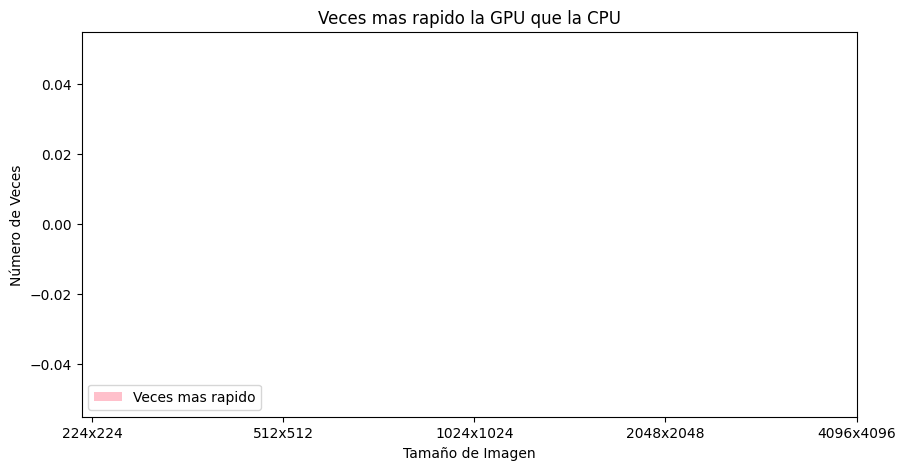

2025-02-11 18:17:52 - DEBUG - Gráfico 1 mostrado. 


In [ ]:


mean_times['Total (s)'] = mean_times['Tiempo CPU (s)'] + mean_times['Tiempo GPU (s)']
mean_times['Veces mas rapido'] = mean_times['Tiempo CPU (s)'] / mean_times['Tiempo GPU (s)']

logs_a_mostrar = mean_times[['Tamaño', 'Veces mas rapido']]
logger.info(f"Numero de veces mas rapido la GPU que la CPU \n {logs_a_mostrar}")

positions = np.arange(len(mean_times))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(positions , mean_times['Veces mas rapido'], width, color='pink',  label='Veces mas rapido')

plt.xlabel('Tamaño de Imagen')
plt.ylabel('Número de Veces')
plt.title('Veces mas rapido la GPU que la CPU')
plt.xticks(positions, mean_times['Tamaño'])
plt.legend()
plt.show()
logger.debug("Gráfico 1 mostrado. ")


### 5 Plot final
- Generamos un plot con la media de cada tamaño de imagen con puntos y luego las unimos con una linea para la CPU y otra para la GPU

2025-02-11 18:23:02 - INFO - Media de datos 
       Tamaño  Tiempo CPU (s)  Tiempo GPU (s)
0    224x224         0.07022             NaN
1    512x512         0.13548             NaN
2  1024x1024         0.48602             NaN
3  2048x2048         1.83482             NaN
4  4096x4096         7.30970             NaN


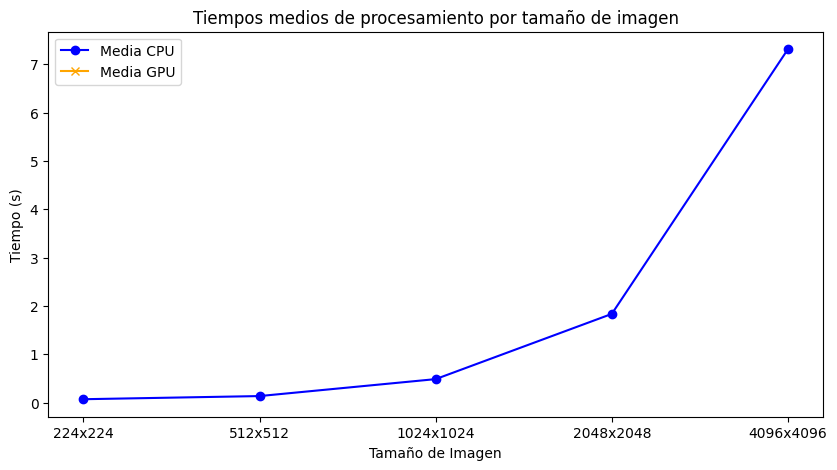

2025-02-11 18:23:02 - DEBUG - Gráfico 2 mostrado.


In [188]:
# Suponiendo que 'mean_times' ya se ha calculado a partir del DataFrame
mean_times['size_num'] = mean_times['Tamaño'].apply(lambda s: int(s.split("x")[0]) if "x" in s else None)
mean_times = mean_times.sort_values('size_num')

logs_a_mostrar = mean_times[['Tamaño', 'Tiempo CPU (s)', 'Tiempo GPU (s)']]
logger.info(f"Media de datos \n {logs_a_mostrar}")

plt.figure(figsize=(10, 5))
plt.plot(mean_times['Tamaño'], mean_times['Tiempo CPU (s)'], marker='o', linestyle='-', color='blue', label='Media CPU')
plt.plot(mean_times['Tamaño'], mean_times['Tiempo GPU (s)'], marker='x', linestyle='-', color='orange', label='Media GPU')
plt.xlabel('Tamaño de Imagen')
plt.ylabel('Tiempo (s)')
plt.title('Tiempos medios de procesamiento por tamaño de imagen')
plt.legend()
plt.show()
logger.debug("Gráfico 2 mostrado.")

## CONCLUSIONES